In [1]:
import numpy as np 
import pandas as pd
import os
import random
import sys
import cv2
import matplotlib
from subprocess import check_output

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
def classes_to_int(label):
    label = label.strip()
    if label == "No DR":  return 0
    if label == "Mild":  return 1
    if label == "Moderate":  return 2
    if label == "Severe":  return 3
    if label == "Proliferative DR":  return 4
    print("Invalid Label", label)
    return 5

def int_to_classes(i):
    if i == 0: return "No DR"
    elif i == 1: return "Mild"
    elif i == 2: return "Moderate"
    elif i == 3: return "Severe"
    elif i == 4: return "Proliferative DR"
    print("Invalid class ", i)
    return "Invalid Class"

train = pd.read_csv('../input/diabetic-data/data/trainLabels.csv')
train.head()  

Using TensorFlow backend.


,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [2]:
NUM_CLASSES = 5
WIDTH = 128
HEIGHT = 128
DEPTH = 3
inputShape = (HEIGHT, WIDTH, DEPTH)
EPOCHS = 15
INIT_LR = 1e-3
BS = 32
ImageNameDataHash = {}
uniquePatientIDList = []

In [3]:
def readTrainData(trainDir):
    global ImageNameDataHash
    images = os.listdir(trainDir)
    print("Number of files in " + trainDir + " is " + str(len(images)))
    for imageFileName in images:
        if (imageFileName == "trainLabels.csv"):
            continue
        imageFullPath = os.path.join(os.path.sep, trainDir, imageFileName)
        img = load_img(imageFullPath)
        arr = img_to_array(img)
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
        if (dim1 < HEIGHT or dim2 < WIDTH or dim3 < DEPTH):
            print("Error image dimensions are less than expected "+str(arr.shape))
        arr = cv2.resize(arr, (HEIGHT,WIDTH)) 
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
        if (dim1 != HEIGHT or dim2 != WIDTH or dim3 != DEPTH):
            print("Error after resize, image dimensions are not equal to expected "+str(arr.shape))
        arr = np.array(arr, dtype="float") / 255.0
        imageFileName = imageFileName.replace('.jpeg','')
        ImageNameDataHash[str(imageFileName)] = np.array(arr) 
    return

In [4]:
from datetime import datetime
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
print("Loading images at..."+ str(datetime.now()))
sys.stdout.flush()
readTrainData("/kaggle/input/diabetic-data/data/train/DR/")
print("Loaded " + str(len(ImageNameDataHash)) + " images at..."+ str(datetime.now())) # 300

Loading images at...2020-07-02 11:32:42.229235
Number of files in /kaggle/input/diabetic-data/data/train/DR/ is 300
Loaded 300 images at...2020-07-02 11:33:54.773492


In [5]:
import csv
def readTrainCsv():
    raw_df = pd.read_csv('/kaggle/input/diabetic-data/data/trainLabels.csv', sep=',')
    print(type(raw_df)) 
    row_count=raw_df.shape[0]  
    col_count=raw_df.shape[1] 
    print("row_count="+str(row_count)+" col count="+str(col_count))
    raw_df["PatientID"] = ''
    header_list = list(raw_df.columns)
    print(header_list) 
    ImageLevelHash = {}
    patientIDList = []
    for index, row in raw_df.iterrows():
        key = row[0] + ''
        patientID = row[0] + ''
        patientID = patientID.replace('_right','')
        patientID = patientID.replace('_left','')
        raw_df.at[index, 'PatientID'] = patientID
        patientIDList.append(patientID)
        ImageLevelHash[key] = str(row[1]) 
                
    global uniquePatientIDList
    uniquePatientIDList = sorted(set(patientIDList))
    count=0;
    for patientID in uniquePatientIDList:
        left_level = ImageLevelHash[str(patientID+'_left')]
        right_level = ImageLevelHash[str(patientID+'_right')]
        if (left_level != right_level):
            count = count+1
    print("count of images with both left and right eye level not matching="+str(count)) # 18
    print("number of unique patients="+str(len(uniquePatientIDList))) # 150
    return raw_df

In [6]:
random.seed(10)
print("Reading trainLabels.csv...")
df = readTrainCsv()

Reading trainLabels.csv...
<class 'pandas.core.frame.DataFrame'>
row_count=300 col count=2
['image', 'level', 'PatientID']
count of images with both left and right eye level not matching=18
number of unique patients=150


In [7]:
for i in range(0,10):
    s = df.loc[df.index[i], 'PatientID'] 
    print(str(i) + " patient's patientID="+str(s))

0 patient's patientID=10
1 patient's patientID=10
2 patient's patientID=13
3 patient's patientID=13
4 patient's patientID=15
5 patient's patientID=15
6 patient's patientID=16
7 patient's patientID=16
8 patient's patientID=17
9 patient's patientID=17


In [8]:
keepImages =  list(ImageNameDataHash.keys())
df = df[df['image'].isin(keepImages)]
print(len(df)) # 300

300


In [9]:
imageNameArr = []
dataArr = []
for index, row in df.iterrows():
    key = str(row[0])
    if key in ImageNameDataHash:
        imageNameArr.append(key)
        dataArr.append(np.array(ImageNameDataHash[key])) 

df2 = pd.DataFrame({'image': imageNameArr, 'data': dataArr})
df2_header_list = list(df2.columns) 
print(df2_header_list) 
print(len(df2)) 

['image', 'data']
300


In [10]:
if len(df) != len(df2):
    print("Error length of df != df2")
    
for idx in range(0,len(df)):
    if (df.loc[df.index[idx], 'image'] != df2.loc[df2.index[idx], 'image']):
        print("Error " + df.loc[df.index[idx], 'image'] +"==" + df2.loc[df2.index[idx], 'image'])
        
print(df2.dtypes)
print(df.dtypes)

image    object
data     object
dtype: object
image        object
level         int64
PatientID    object
dtype: object


In [11]:
df = pd.merge(df2, df, left_on='image', right_on='image', how='outer')
df_header_list = list(df.columns) 
print(df_header_list) 
print(len(df)) 
print(df.sample())

['image', 'data', 'level', 'PatientID']
300
        image    ...    PatientID
246  286_left    ...          286

[1 rows x 4 columns]


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
<class 'numpy.ndarray'>
(128, 128, 3)


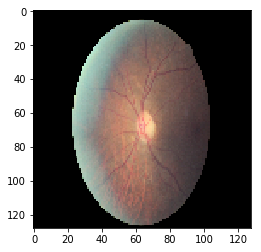

Sample Image


In [12]:
sample0 = df.loc[df.index[0], 'data']
print(sample0)
print(type(sample0))
print(sample0.shape)
from matplotlib import pyplot as plt
plt.imshow(sample0, interpolation='nearest')
plt.show()
print("Sample Image")

In [13]:
X = df['data']
Y = df['level']
Y = np.array(Y)
Y =  to_categorical(Y, num_classes=NUM_CLASSES)

In [14]:
print("Parttition data into 75:25...")
sys.stdout.flush()
print("Unique patients in dataframe df=" + str(df.PatientID.nunique())) 
unique_ids = df.PatientID.unique()
print('unique_ids shape='+ str(len(unique_ids))) 
train_ids, valid_ids = train_test_split(unique_ids, test_size = 0.25, random_state = 10) 
trainid_list = train_ids.tolist()
print('trainid_list shape=', str(len(trainid_list))) 

traindf = df[df.PatientID.isin(trainid_list)]
valSet = df[~df.PatientID.isin(trainid_list)]

Parttition data into 75:25...
Unique patients in dataframe df=150
unique_ids shape=150
trainid_list shape= 112


In [15]:
print(traindf.head())
print(valSet.head())

traindf = traindf.reset_index(drop=True)
valSet = valSet.reset_index(drop=True)

print(traindf.head())
print(valSet.head())

      image    ...    PatientID
0   10_left    ...           10
1  10_right    ...           10
6   16_left    ...           16
7  16_right    ...           16
8   17_left    ...           17

[5 rows x 4 columns]
       image    ...    PatientID
2    13_left    ...           13
3   13_right    ...           13
4    15_left    ...           15
5   15_right    ...           15
20   25_left    ...           25

[5 rows x 4 columns]
      image    ...    PatientID
0   10_left    ...           10
1  10_right    ...           10
2   16_left    ...           16
3  16_right    ...           16
4   17_left    ...           17

[5 rows x 4 columns]
      image    ...    PatientID
0   13_left    ...           13
1  13_right    ...           13
2   15_left    ...           15
3  15_right    ...           15
4   25_left    ...           25

[5 rows x 4 columns]


In [16]:
trainX = traindf['data']
trainY = traindf['level']

valX = valSet['data']
valY = valSet['level']

print('trainX shape=', trainX.shape[0], 'valX shape=', valX.shape[0]) 

trainX shape= 224 valX shape= 76


In [17]:
trainY =  to_categorical(trainY, num_classes=NUM_CLASSES)
valY =  to_categorical(valY, num_classes=NUM_CLASSES)

In [18]:
print("Generating images...")
sys.stdout.flush()
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

Generating images...


In [19]:
def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=inputShape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim=NUM_CLASSES, activation='softmax'))
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [20]:
print("Reshaping trainX at..."+ str(datetime.now()))
print(type(trainX))
print(trainX.shape) 
from numpy import zeros
Xtrain = np.zeros([trainX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(trainX.shape[0]): 
    Xtrain[i] = trainX[i]
print(Xtrain.shape) 
print("Reshaped trainX at..."+ str(datetime.now()))

Reshaping trainX at...2020-07-02 11:34:16.609849
<class 'pandas.core.series.Series'>
(224,)
(224, 128, 128, 3)
Reshaped trainX at...2020-07-02 11:34:16.673909


In [21]:
print("Reshaping valX at..."+ str(datetime.now()))
print(type(valX)) 
print(valX.shape) 
from numpy import zeros
Xval = np.zeros([valX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(valX.shape[0]):
    Xval[i] = valX[i]
print(Xval.shape)
print("Reshaped valX at..."+ str(datetime.now()))

Reshaping valX at...2020-07-02 11:34:16.685275
<class 'pandas.core.series.Series'>
(76,)
(76, 128, 128, 3)
Reshaped valX at...2020-07-02 11:34:16.707742


compiling model...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
__________

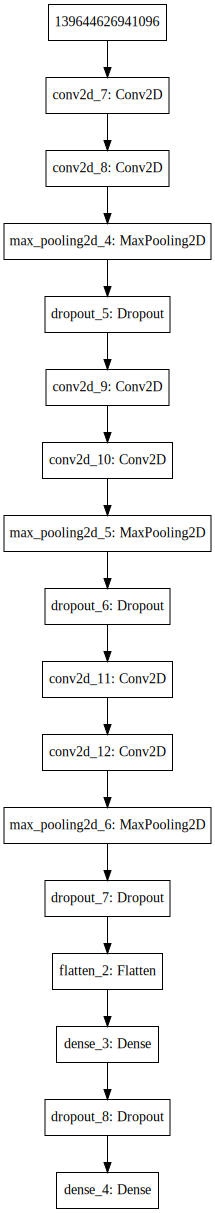

In [25]:
print("compiling model...")
sys.stdout.flush()
model = createModel()

from keras.utils import print_summary
print_summary(model, line_length=None, positions=None, print_fn=None)

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [26]:
print("training network...")
sys.stdout.flush()
H = model.fit_generator(aug.flow(Xtrain, trainY, batch_size=BS), \
    validation_data=(Xval, valY), \
    steps_per_epoch=len(trainX) // BS, \
    epochs=EPOCHS, verbose=1)

print("Saving model to disk")
sys.stdout.flush()
model.save("/kaggle/working/mymodel")

training network...
Epoch 1/15
7/7 [==============================] - 18s 3s/step - loss: 1.0551 - acc: 0.6607 - val_loss: 1.1701 - val_acc: 0.7763
Epoch 2/15
7/7 [==============================] - 16s 2s/step - loss: 0.8977 - acc: 0.7545 - val_loss: 0.8982 - val_acc: 0.7763
Epoch 3/15
7/7 [==============================] - 16s 2s/step - loss: 0.9133 - acc: 0.7545 - val_loss: 0.8363 - val_acc: 0.7763
Epoch 4/15
7/7 [==============================] - 17s 2s/step - loss: 0.8793 - acc: 0.7545 - val_loss: 0.8430 - val_acc: 0.7763
Epoch 5/15
7/7 [==============================] - 16s 2s/step - loss: 0.8870 - acc: 0.7545 - val_loss: 0.8285 - val_acc: 0.7763
Epoch 6/15
7/7 [==============================] - 16s 2s/step - loss: 0.8868 - acc: 0.7545 - val_loss: 0.8421 - val_acc: 0.7763
Epoch 7/15
7/7 [==============================] - 16s 2s/step - loss: 0.8485 - acc: 0.7545 - val_loss: 0.7886 - val_acc: 0.7763
Epoch 8/15
7/7 [==============================] - 17s 2s/step - loss: 0.8458 - acc: 

Generating plots...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-123>", line 2, in initialize
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 87, in catch_conf

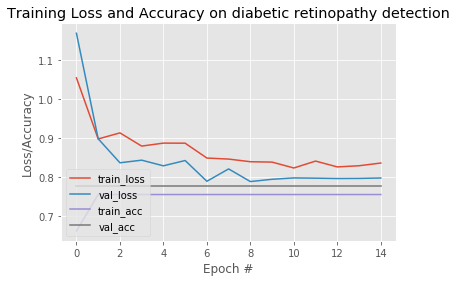

In [27]:
print("Generating plots...")
sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = EPOCHS
matplotlib.pyplot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["acc"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
matplotlib.pyplot.title("Training Loss and Accuracy on diabetic retinopathy detection")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot.png")